In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

# Scikit-Learn
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Data Encoding and Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Natural Language Processing(NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Word Embedding
import gensim
from gensim.models import Word2Vec

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
df = pd.read_csv('IntervieweeDataset.csv')

In [5]:
df.shape

(21256, 52)

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop(df.iloc[:, 8:18], axis=1, inplace=True)

In [8]:
df.drop(['Name',
        'Pre Interview Check',
         'Experienced Candidate (Nature of work)',
         'Call-pitch Elements used during the call Sales Scenario',
         "But, my child's exam are going on now, so we will keep the counselling session after the exams get over.(Time: Favourable pitch: Counsellor hype)",
         'Let me discuss it with my child',
         "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app.",
         'Comments',
         'RedFlags Comments in Interview',
         'Whether joined the company or not\n',
         'Role Location to be given to the candidate'
        ], axis=1, inplace=True)

In [9]:
df.columns = df.columns.str.removesuffix(" .1")
df.columns = df.columns.str.removesuffix(".1")

In [10]:
df.rename(columns={'What was the type of Role?\t': 'What was the type of Role?'}, inplace=True)

In [11]:
df.rename(columns = {'Has acquaintance in Company and has spoken to him/her before applying?' : 'Acquaintance and Referral'}, inplace=True)
df.rename(columns = {'Type of Graduation/Post Graduation' : 'Education'}, inplace=True)
df.rename(columns= {'Mode of interview given by candidate?' : 'Mode of Interview'}, inplace=True)

In [12]:
df['id'] = df.index

In [13]:
df.columns

Index(['Age', 'Gender', 'Education', 'Marital status', 'Mode of Interview',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Acquaintance and Referral', 'Candidate Status',
       'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?',
       'How many slides candidate have submitted in PPT?', 'Role acceptance',
       'Interview Verdict', 'Candidate is willing to relocate',
       'Confidence based on Introduction (English)',
       'Confidence based on the topic given ',
       'Confidence Based on the PPT Question',
       'Confidence based on the sales scenario',
       'Structured Thinking (In regional only)',
       'Structured Thinking Based on the PPT Question',
       'Structured Thinking( Call pitch)',
       'Regional fluency based on the topic given ',
       'Regional fluency Based on the PPT Quest

In [14]:
education_mapping = {
    'Engineering & Technology': [
        'B.E / B-Tech', 'M.E / M-Tech', 'B-Tech - INTEGRATED', 'BE - CSe and CDAC',
        'B.ENG', 'Bachelors of planning', 'B.Arch', 'Bachelor of Architecture', 'B.ARC'
    ],
    'Science & Medical': [
        'BSc or MSc', 'BSC', 'MS', 'Masters in biotechnology', 'PG - msc biochemistry',
        'Bio science', 'masters in biology', 'biotech', 'Masters of Statistics',
        'Bachelors in biotechnology', 'Ph D genetics', 'MBBS', 'Bachelor in medical lab',
        'B.Physiotherapist', 'B.pharma', 'M.pharma', 'B -pharm', 'B.PHARMA',
        'PHARMA D', 'pharm D', 'M.Pharma', 'Bachelors in dental',
        'Masters in Clinical Psychology', 'B.voc in applied clinical psychology'
    ],
    'Commerce & Business': [
        'B.com', 'BCOM COMPUTERS', 'Bcom computers', 'bcom -pa', 'M.com',
        'MBA', 'MBA- 2019', 'MBA agro business', 'PGDM', 'pgdm', 'PGDM 2022',
        'PGDM marketing', 'PG diploma in banking', 'PG DIPLOMA IN BANKING',
        'Masters in banking and insurance', 'BBA or BBM', 'BBM',
        'Bachelor of Business Economics (B.B.E.)', 'PGPM', 'PGPM in marketing',
        'PGPCEM', 'PGDBS', 'B.Voc - Banking & Finance'
    ],
    'Humanities & Social Sciences': [
        'BA/MA', 'LLB', 'LLM', 'MPhil', 'M.phil', 'Mphil 2020', 'PHD', 'doctorate',
        'Masters of Social Work (MSW)', 'msw', 'msw-hr-2014', 'MSW HRM',
        'Public administration', 'Masters in comparative religion', 'Masters in archeology',
        'English Honors', 'MASTERS IN SOCIAL SCIENCE', 'Bengali Honors'
    ],
    'Mass Communication & Media': [
        'B.comm (Bachelor of mass comm.)', 'Bachelor mass communication',
        'mass media', 'masss media', 'mass comm', 'Mass comm', 'BMM ( MAss Media)',
        'BJMC', 'MJMC 2020', 'Masters in mass communication', 'MASTERS IN MASS COM',
        'Masters in Convergent Journalism', 'master maas comm', 'master in electronic media'
    ],
    'Vocational & Professional Courses': [
        'B.ed (Teaching)', 'B.ed', 'B.ED', 'M.ed', 'D.el.ed', 'd el. ed', 'Dled',
        'Bachelors in fisheries science', 'Bachelors in tourism', 'Bachelor of Tourism',
        'travel & toursim', 'Bachelors in design', 'B.Design', 'Bachelors in hospitality',
        "Bachelor's in Hospitality", 'Hotel Management', 'Masters in fashion designing',
        'Masters in hospitality', 'Masters in design', 'food technology',
        'BVoc', 'B.VOC', 'B.vocational', 'B.voc - IT', 'B.voc networking and mobile applications',
        'bachelors of vocational - automobile', 'Bpharma', 'Mpharma', 'Diploma', 'Diploma in engr',
        'PGDCA', 'PGD', 'pgdca', 'PGD (Bachelor of Library Science)', 'BMIT',
        'PGDF', 'PGDA', 'MFC', 'MLIS', 'BMS', 'BMS marketing', 'bms', 'bms-2020',
        'Bachelor in IT', 'BCA/MCA', 'CSE', 'PDGM Advance Computing'
    ]
}

# Function to map education to categories
def categorize_education(education):
    for category, degrees in education_mapping.items():
        if education in degrees:
            return category
    return 'Other'  

In [15]:
def format_education(df):
    df = df.copy()
    df['Education'] = df['Education'].fillna('Unknown').apply(lambda x: categorize_education(x))
    return df

In [16]:
def convert_age(df):
    df = df.copy()
    df['Age'] = pd.to_numeric(df['Age'].astype(str).str.replace('+', '', regex=False), errors='coerce')
    df['Age'] = pd.cut(df['Age'], 
                       bins=[18, 22, 25, 28, 32, 35, float('inf')],
                       labels=['18-22', '23-25', '26-28', '29-32', '33-35', '35+'], 
                       right=True)
    return df

In [17]:
def label_encoder(df):
    df = df.copy()
    label_encoders = {}
    categorical_cols = [
        'Gender', 'Marital status', 'Mode of Interview',
        'Does the candidate has mother tongue influence while speaking english.',
        'Acquaintance and Referral', 'Currently Employed',
        'Candidate is willing to relocate'
    ]
    
    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown')
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]) 
        label_encoders[col] = le  
        
    return df

In [18]:
# def rename_columns(df, feature_names):
#     """ Convert NumPy array to DataFrame and rename columns by removing 'remainder__' """
#     df = pd.DataFrame(df, columns=feature_names)
#     df.columns = [str(col).replace('remainder__', '') for col in df.columns]
#     return df

In [19]:
df['Interview Verdict'] = df['Interview Verdict'].replace({'Premium Select':'Select', 'Borderline Select':'Select', 'Borderline Reject':'Reject'})
df['Interview Verdict'].unique()

array(['Reject', 'Select'], dtype=object)

In [20]:
le_verdict = LabelEncoder()
df['Interview Verdict'] = le_verdict.fit_transform(df['Interview Verdict'])

# Pipeline

In [22]:
preprocessing_pipeline = Pipeline([
    ('categorize_education', FunctionTransformer(format_education, validate=False)),
    ('convert_age', FunctionTransformer(convert_age, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),    
    ('encode_labels', ColumnTransformer(transformers=[
        ('t1', OneHotEncoder(sparse_output=False, drop='first'), ['Fluency in English based on introduction', 'Candidate Status', 'Education', 'What was the type of Role?']),
        ('t2', OrdinalEncoder(categories=[['Fresher', '0-1.99', '2-2.99', '3-3.99', '4-4.99', '5-5.99', '6-6.99', '7+']]), ['Last Fixed CTC (lakhs) ']),
        ('t3', OrdinalEncoder(categories=[['Fresher(<6 months)', '6-11.99 Months', '12-17.99 Months', '18-23.99 Months', '24-29.99 Months', '30-35.99 Months', '36-47.99 Months', '48+ Months']]), ['Experienced candidate - (Experience in months)']),
        ('t4', OrdinalEncoder(categories=[['No', 'Yes : Think and says yes.(Shows some hesitation)', 'Emphatic Yes']]), ['Role acceptance']),
        ('t5', OrdinalEncoder(categories=[['18-22', '23-25', '26-28', '29-32', '33-35', '35+']]), ['Age']),
        ('t6', OrdinalEncoder(categories=[['Wrong File/PPT Submitted', 'No slides or Wrong PPT submitted', "Only Name Slide/No Slide Attached (Blank/Template PPT Submitted)", '1 slide', '2 - 3 slides', '4 - 5 slides', '5 - 6 slides', 'More than 6 slides']]), ['How many slides candidate have submitted in PPT?'])
    ],remainder='passthrough')),
    # ('rename_columns', FunctionTransformer(rename_columns, validate=False)),
    ('scaler', StandardScaler()),
    ('model1', RandomForestClassifier())
])

In [23]:
''' Visualize the Pipeline '''

set_config(display='diagram')
preprocessing_pipeline

Pipeline(steps=[('categorize_education',
                 FunctionTransformer(func=<function format_education at 0x00000265A22811C0>)),
                ('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x00000265A2280E00>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x00000265A2281120>)),
                ('encode_labels',
                 ColumnTransformer(remainder='passthrough',
                                   trans...
                                                  OrdinalEncoder(categories=[['Wrong '
                                                                              'File/PPT '
                                                                              'Submitted',
                                                                              'No '
                                                                              'slides '
                                                                              'or '
                                                                              'Wrong '
                                                                              'PPT '
                                                                              'submitted',
                                                                              'Only '
                                                                              'Name '
                                                                              'Slide/No '
                                                                              'Slide '
                                                                              'Attached '
                                                                              '(Blank/Template '
                                                                              'PPT '
                                                                              'Submitted)',
                                                                              '1 '
                                                                              'slide',
                                                                              '2 '
                                                                              '- '
                                                                              '3 '
                                                                              'slides',
                                                                              '4 '
                                                                              '- '
                                                                              '5 '
                                                                              'slides',
                                                                              '5 '
                                                                              '- '
                                                                              '6 '
                                                                              'slides',
                                                                              'More '
                                                                              'than '
                                                                              '6 '
                                                                              'slides']]),
                                                  ['How many slides candidate '
                                                   'have submitted in '
                                                   'PPT?'])])),
                ('scaler', StandardScaler()),
                ('model1', RandomForestClassifier())])

# Data Splitting

In [25]:
X = df.drop(columns=['Interview Verdict', 'id']).copy()
y = df['Interview Verdict']

In [26]:
X.columns

Index(['Age', 'Gender', 'Education', 'Marital status', 'Mode of Interview',
       'Fluency in English based on introduction',
       'Does the candidate has mother tongue influence while speaking english.',
       'Acquaintance and Referral', 'Candidate Status',
       'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'What was the type of Role?',
       'How many slides candidate have submitted in PPT?', 'Role acceptance',
       'Candidate is willing to relocate',
       'Confidence based on Introduction (English)',
       'Confidence based on the topic given ',
       'Confidence Based on the PPT Question',
       'Confidence based on the sales scenario',
       'Structured Thinking (In regional only)',
       'Structured Thinking Based on the PPT Question',
       'Structured Thinking( Call pitch)',
       'Regional fluency based on the topic given ',
       'Regional fluency Based on the PPT Question',
       'Regiona

In [27]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: Interview Verdict, dtype: int32

In [28]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train.dtypes, y_train.dtypes

(Age                                                                        object
 Gender                                                                     object
 Education                                                                  object
 Marital status                                                             object
 Mode of Interview                                                          object
 Fluency in English based on introduction                                   object
 Does the candidate has mother tongue influence while speaking english.     object
 Acquaintance and Referral                                                  object
 Candidate Status                                                           object
 Last Fixed CTC (lakhs)                                                     object
 Currently Employed                                                         object
 Experienced candidate - (Experience in months)                             object
 Wha

In [31]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')
print(f'Length of y_train: {len(y_train)}')
print(f'Length of y_test: {len(X_test)}')

Length of X_train: 14944
Length of X_test: 3737
Length of y_train: 14944
Length of y_test: 3737


In [32]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [33]:
X_train.head()

,Age,Gender,Education,Marital status,Mode of Interview,Fluency in English based on introduction,Does the candidate has mother tongue influence while speaking english.,Acquaintance and Referral,Candidate Status,Last Fixed CTC (lakhs),...,Structured Thinking (In regional only),Structured Thinking Based on the PPT Question,Structured Thinking( Call pitch),Regional fluency based on the topic given,Regional fluency Based on the PPT Question,Regional fluency based on the sales scenario,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score
3159,26,Male,B.E / B-Tech,Married,Mobile,Taking gaps while speaking due to lack of cont...,No,No,Experienced in non client facing(equal to or m...,3-3.99,...,2,2,2,1,1.0,3.0,8,6,5,38
20358,20,Male,BA/MA,Unmarried,Mobile,Taking gaps while speaking due to lack of cont...,No,No,Lateral(2021 and before with (less than 6 mont...,Fresher,...,3,3,2,3,3.0,3.0,9,8,9,52
6317,21,Male,BCA/MCA,Unmarried,Laptop,Taking gaps while speaking due to lack of cont...,No,No,Fresher(only 2022 grad),Fresher,...,2,2,2,1,1.0,1.0,8,6,3,34
19183,23,Male,B.E / B-Tech,Unmarried,Mobile,Able to speak sentences in a clear/coherent wa...,No,No,Lateral(2021 and before with (less than 6 mont...,Fresher,...,3,2,2,3,3.0,3.0,12,7,9,56
8608,23,Male,B.com (Bachelor of commerce),Unmarried,Mobile,Trying but Not Able to speak clearly & Fumbles...,No,No,Fresher(only 2022 grad),Fresher,...,1,1,1,1,2.0,2.0,6,3,5,28


# Fit Pipeline

In [35]:
preprocessing_pipeline.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('categorize_education',
                 FunctionTransformer(func=<function format_education at 0x00000265A22811C0>)),
                ('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x00000265A2280E00>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x00000265A2281120>)),
                ('encode_labels',
                 ColumnTransformer(remainder='passthrough',
                                   trans...
                                                  OrdinalEncoder(categories=[['Wrong '
                                                                              'File/PPT '
                                                                              'Submitted',
                                                                              'No '
                                                                              'slides '
                                                                              'or '
                                                                              'Wrong '
                                                                              'PPT '
                                                                              'submitted',
                                                                              'Only '
                                                                              'Name '
                                                                              'Slide/No '
                                                                              'Slide '
                                                                              'Attached '
                                                                              '(Blank/Template '
                                                                              'PPT '
                                                                              'Submitted)',
                                                                              '1 '
                                                                              'slide',
                                                                              '2 '
                                                                              '- '
                                                                              '3 '
                                                                              'slides',
                                                                              '4 '
                                                                              '- '
                                                                              '5 '
                                                                              'slides',
                                                                              '5 '
                                                                              '- '
                                                                              '6 '
                                                                              'slides',
                                                                              'More '
                                                                              'than '
                                                                              '6 '
                                                                              'slides']]),
                                                  ['How many slides candidate '
                                                   'have submitted in '
                                                   'PPT?'])])),
                ('scaler', StandardScaler()),
                ('model1', RandomForestClassifier())])

In [36]:
''' Make Predictions '''
y_pred = preprocessing_pipeline.predict(X_test)
len(y_pred)

3737

In [37]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)*100
print(f"Accuracy is {accuracy:.2f}%")

Accuracy is 87.96%


# Now using PyTorch

In [42]:
preprocessing_only = Pipeline(preprocessing_pipeline.steps[:-1])

In [44]:
X_train = preprocessing_only.fit_transform(X_train, y_train)
X_test = preprocessing_only.transform(X_test)

In [46]:
if y_train.dtype == 'object' or y_train.dtype.name == 'category':
    le_y = LabelEncoder()
    y_train = le_y.fit_transform(y_train)
    y_test = le_y.transform(y_test)

In [56]:
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

In [58]:
type(y_train_array)

numpy.ndarray

In [62]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

In [64]:
type(X_train_tensor), type(y_train_tensor)

(torch.Tensor, torch.Tensor)

# Dataset Class

In [82]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [84]:
train_data = CustomDataset(X_train_tensor, y_train_tensor)
test_data = CustomDataset(X_test_tensor, y_test_tensor)

# DataLoader

In [86]:
BATCH_SIZE = 16

In [88]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [91]:
len(train_data), len(test_data)

(14944, 3737)

In [94]:
len(train_dataloader), len(test_dataloader)

(934, 234)

# Define a Model

In [100]:
class RecommenderModel(nn.Module):
    def __init__(self, input_size, hidden_units):
        super().__init__()

        # Fully Connected Layers
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units // 2)
        self.fc3 = nn.Linear(hidden_units // 2, 1)

        # Activation Functions & Regularization
        self.dropout = nn.Dropout(0.3)
        self.batchnorm1 = nn.BatchNorm1d(hidden_units)
        self.batchnorm2 = nn.BatchNorm1d(hidden_units // 2)


    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        return self.fc3(x).squeeze()

In [106]:
''' Initializing the model '''
input_shape = X_train.shape[1]
hidden_units = 128

model_1 = RecommenderModel(input_shape, hidden_units)
model_1.to(device)

RecommenderModel(
  (fc1): Linear(in_features=40, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [111]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 15

In [113]:
''' Loss Function and Optimizer '''
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# Training Loop

In [121]:
def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy,
              device:torch.device):

    train_loss, train_acc = 0,0
    model.train()

    for features, labels in dataloader:
        X, y = features.to(device), labels.to(device)
        # Forward Pass
        # y_pred = model(X)
        y_logits = model(X).squeeze()
        # y_pred = torch.round(torch.sigmoid(y_logits))
        y_pred = (y_logits > 0).float()

        # Calculate Loss and Accuracy per batch
        # loss = loss_function(y_pred, y)
        loss = loss_function(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy(y, y_pred).item()*100

        # Set gradients to zero
        optimizer.zero_grad()

        # Back Propogation
        loss.backward()

        # Update the Parameters
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

# Testing Loop

In [124]:
def test_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             accuracy,
             device:torch.device):

    test_loss, test_acc = 0,0

    model.eval()
    with torch.inference_mode():
        for features, labels in dataloader:
            X, y = features.to(device), labels.to(device)
            # Forward Pass
            # test_pred = model(X)
            test_logits = model(X).squeeze()
            # test_pred = torch.round(torch.sigmoid(test_logits))
            test_pred = (test_logits > 0).float()
            
            # Calculate Loss and Accuracy per batch
            loss = loss_function(test_logits, y)
            test_loss += loss.item()
            test_acc += accuracy(y, test_pred).item()*100

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

# Combining Training and Testing Loop into evaluate()

In [127]:
def evaluate(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             optimizer:torch.optim.Optimizer,
             accuracy,
             device:torch.device,
             epochs:int = 5):

    model.to(device)
    # Create empty result dictionary
    results = {'train_loss':[],
              'train_acc':[],
              'test_loss':[],
              'test_acc':[]}

    # Loop through training and testing steps for the number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          optimizer=optimizer,
                                          accuracy=accuracy,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_function=loss_function,
                                          accuracy=accuracy,
                                          device=device)

        print(f'Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%')      

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [130]:
torch.manual_seed(42)
accuracy = Accuracy(task='binary').to(device)

model_0_results = evaluate(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_function=loss_function,
                        optimizer=optimizer,
                        accuracy=accuracy,
                        device=device,
                        epochs=epochs)

Training Loss: 0.36137 | Training Accuracy: 84.30% | Testing Loss: 0.30531 | Testing Accuracy: 86.93%
Training Loss: 0.33875 | Training Accuracy: 85.51% | Testing Loss: 0.30709 | Testing Accuracy: 86.92%
Training Loss: 0.33030 | Training Accuracy: 85.98% | Testing Loss: 0.29689 | Testing Accuracy: 87.19%
Training Loss: 0.32522 | Training Accuracy: 86.06% | Testing Loss: 0.29704 | Testing Accuracy: 87.38%
Training Loss: 0.32388 | Training Accuracy: 86.28% | Testing Loss: 0.29860 | Testing Accuracy: 87.38%
Training Loss: 0.32163 | Training Accuracy: 86.42% | Testing Loss: 0.29715 | Testing Accuracy: 86.81%
Training Loss: 0.32020 | Training Accuracy: 86.39% | Testing Loss: 0.29596 | Testing Accuracy: 87.29%
Training Loss: 0.31917 | Training Accuracy: 86.36% | Testing Loss: 0.29308 | Testing Accuracy: 87.00%
Training Loss: 0.31428 | Training Accuracy: 86.86% | Testing Loss: 0.28796 | Testing Accuracy: 87.37%
Training Loss: 0.31306 | Training Accuracy: 86.99% | Testing Loss: 0.28982 | Testi

# Loss and Accuracy Curves

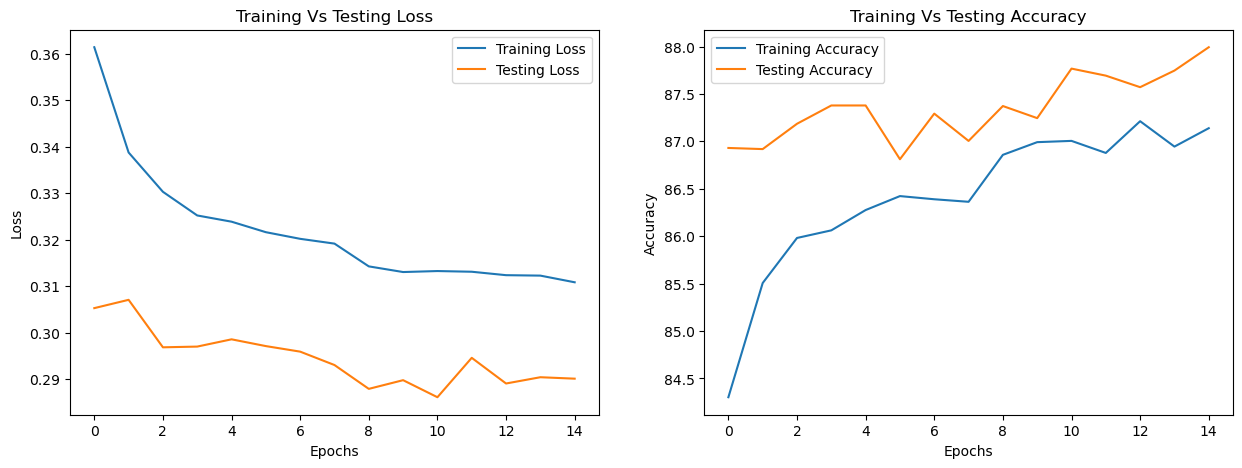

In [134]:
plt.figure(figsize=(15,5))
epochs = range(len(model_0_results['train_loss']))

plt.subplot(1,2,1)
plt.plot(epochs, model_0_results['train_loss'], label='Training Loss')
plt.plot(epochs, model_0_results['test_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Vs Testing Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, model_0_results['train_acc'], label='Training Accuracy')
plt.plot(epochs, model_0_results['test_acc'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Vs Testing Accuracy')
plt.legend()

plt.show()